#### Chapter 3 Classification

#### Index



Studying MNIST data 

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784',version=1) #getting the MNIST data 
mnist.keys() # displaying the keys 

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, Y = mnist['data'],mnist['target']
X.shape

(70000, 784)

there are 70,000 images(observations) in the data and 784 features 

In [4]:
Y.shape

(70000,)

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)


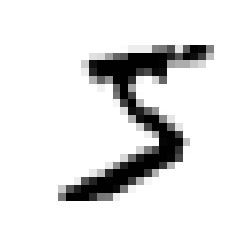

In [6]:
plt.imshow(some_digit_image,cmap=mpl.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
Y[0]

'5'

In [8]:
Y = Y.astype(np.int8) # need this conversion to convert string values to ints

In [9]:
Y

array([5, 0, 4, ..., 4, 5, 6], dtype=int8)

In [10]:
x_train,x_test,y_train,y_test = X[:60000],X[60000:],Y[:60000],Y[60000:]

Training a binary tree classifier  

In [11]:
# creating a binary classifier which tell if the value is 5 or not 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Stochastic Gradient Descent classifier would be used as it can train instances independently and  its capable of handling very large datasets. Hence its best suited for online learning

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train,y_train_5) 


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

#### Measuring the accuracy using cross validation

Some times we would need more control over the cross-validation process than what scikit-learn provides

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [15]:
skfolds = StratifiedKFold(n_splits=3,random_state=42)

In [18]:
for train_index,test_index in skfolds.split(x_train,y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds,y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


Implementing the cross val score with the libarary from scikit learn 

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(sgd_clf,x_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

The accuracy is over 95% across all folds. 

In [22]:
from sklearn.base import BaseEstimator

class Not5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [23]:
not5class = Not5Classifier()
cross_val_score(not5class,x_train,y_train_5,cv=3,scoring='accuracy')


array([0.91125, 0.90855, 0.90915])

In the MNIST dataset 5's occur 10% of the time, so our not5classifier guess 90% of the time its not 5. 

Accuracy is generally not preferred performance measure for classifiers, especially when the dataset is skewed. 


#### Confusion Matrix

A better way to evaluate the performance of a classifier. 
>Count the number of times instances of class A are classified as class B

In [25]:
from sklearn.model_selection import cross_val_predict 
# gives the number of prediction made at each fold.

In [26]:
y_train_pred = cross_val_predict(sgd_clf,x_train,y_train_5,cv=3)

In [27]:
from sklearn.metrics import confusion_matrix

In [31]:
cnf_array = confusion_matrix(y_train_5,y_train_pred)

In [33]:
cnf_array

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [29]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

A perfect classifier would give only true positives or true negatives with non zero value 

Getting the accuracy of the positive prediction 

$$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$

Precision is used with other metric called *recall* or *sensitivity* or *True positive rate*

$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$
$$ \text{The ratio of positive instances that are correctly detected by the classifier}$$

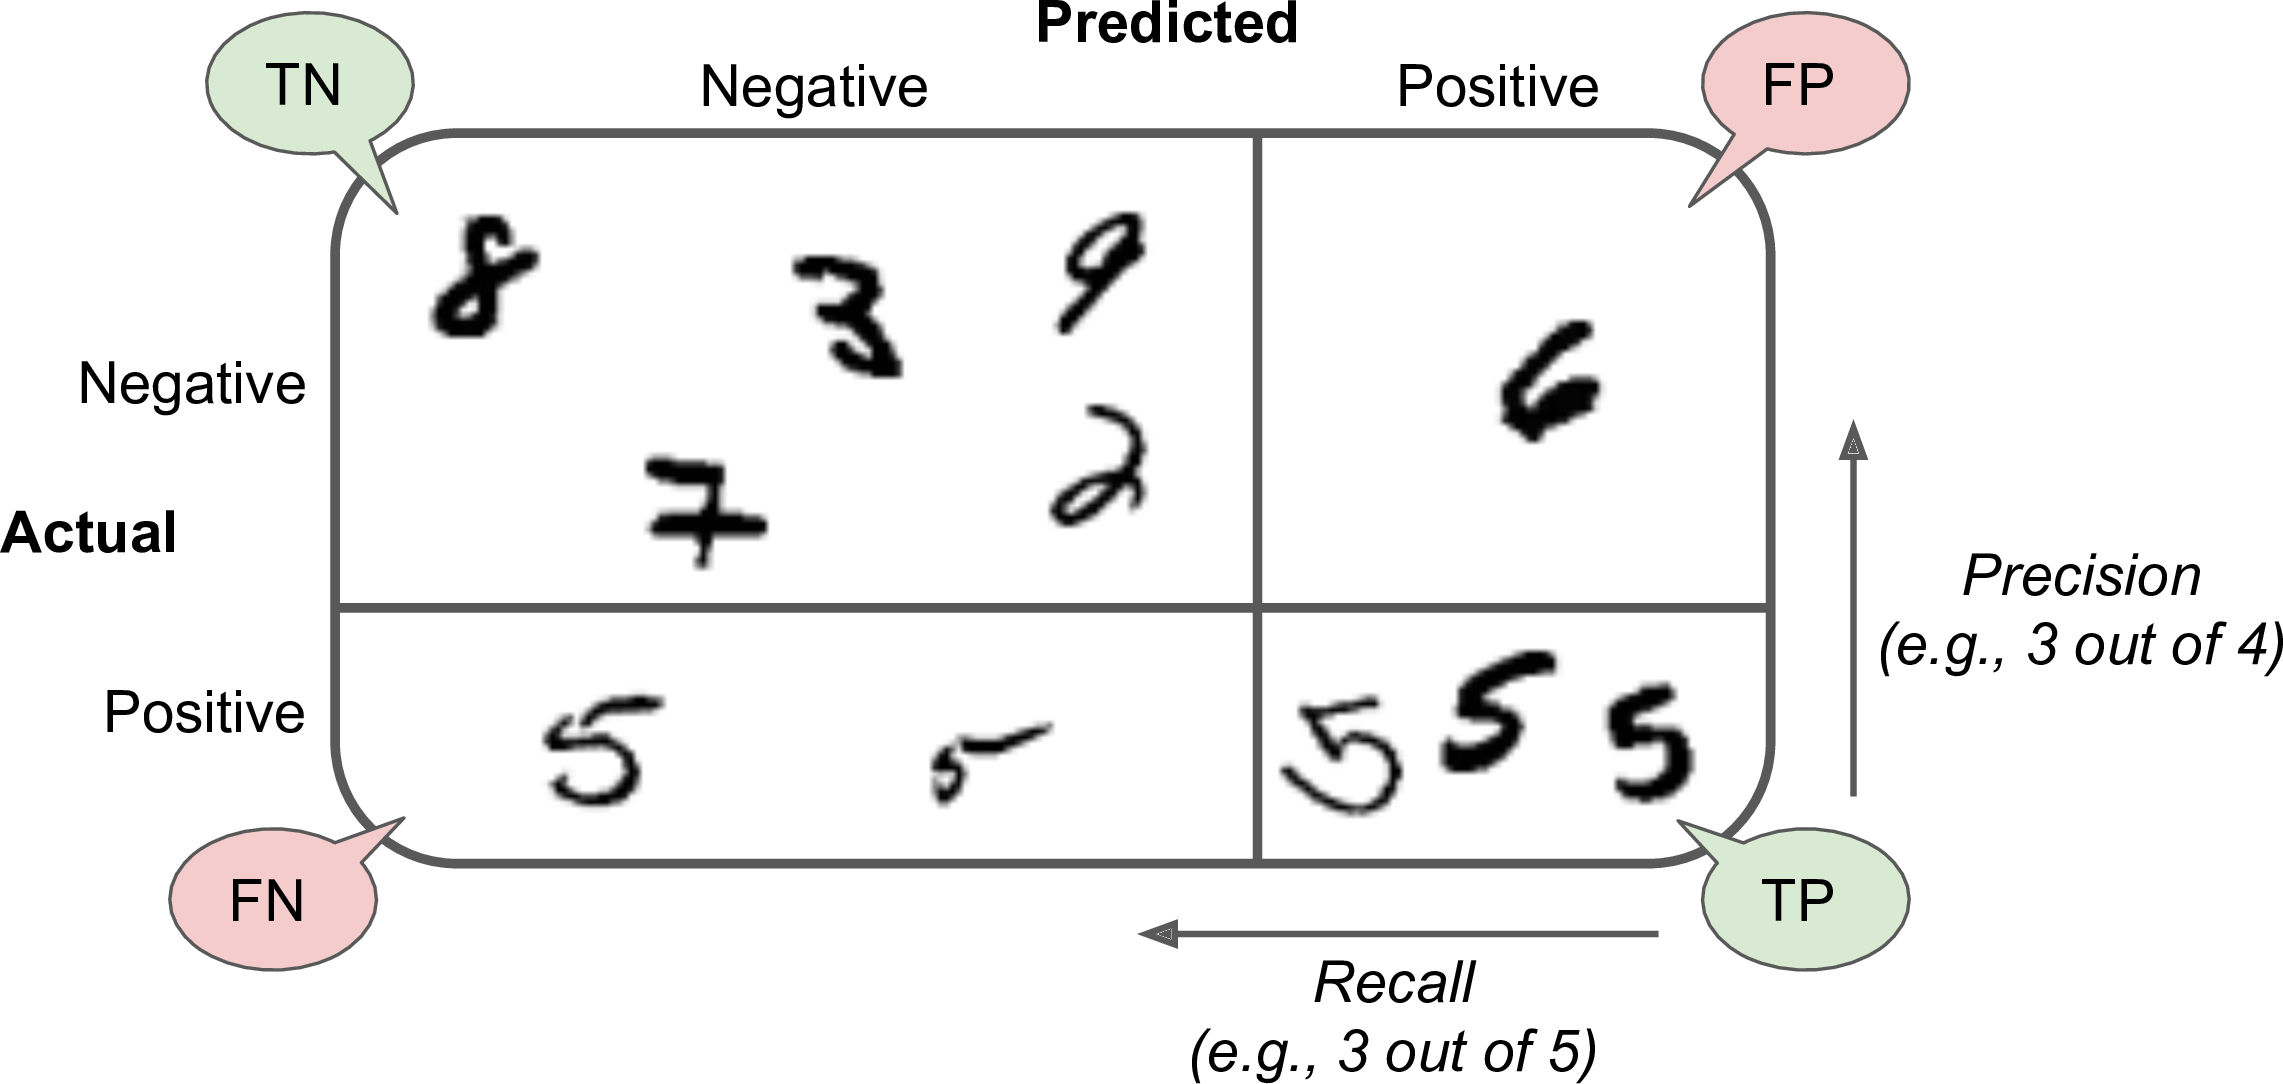

In [35]:
print("Precision:",cnf_array[1][1] / (cnf_array[1][1] + cnf_array[0][1]))
print("Recall:",cnf_array[1][1] / (cnf_array[1][1] + cnf_array[1][0]))

Precision: 0.8370879772350012
Recall: 0.6511713705958311


#### Precision and Recall

In [36]:
from sklearn.metrics import precision_score,recall_score

In [37]:
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [38]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

F1 score
> Its the harmonic mean of precision and recall.

Regular mean treats values equally where as harmonic mean gives much more weight to low values. 


In [39]:
# computing the F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

There is a trade off between the precision and the recall trade off.


#### Precision/Recall Tradeoff

SGDClassifier - makes decision for each instance <br>
if score based on a decision function is > threshold <br>
    ....assigns the instance to positive class <br>
else <br>
    ....assigns the instance to negative class<br>

In [41]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [42]:
threshold = 0 
y_some_digit_pred = (y_scores > threshold)

In [43]:
 y_some_digit_pred

array([ True])

In [45]:
threshold =8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

The classifier misses the prediction of 5's when the threshold is increased to 8000
thus increasing the recall value. 

how would you know which one to use. we need to get the scores of all the instances in the traininng set using the cross_val_predict() 



In [46]:
y_scores = cross_val_predict(sgd_clf,x_train,y_train_5,cv=3,method='decision_function')

Computing the precision and recall for all possible thresholds using predict_recall_curve()

In [48]:
from sklearn.metrics import precision_recall_curve

In [50]:
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

In [75]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"w--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"r-",label="Recall")
    plt.title("Threshold versus Recall & Precision")
    plt.xlabel("Thresholds")
    plt.ylabel("Recall & Precision")
    plt.grid(linestyle='--')


ValueError: x and y must have same first dimension, but have shapes (3908,) and (59966,)

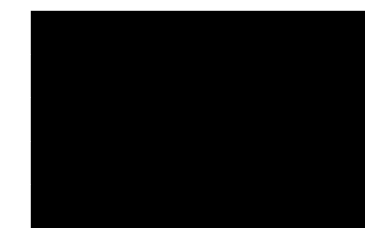

In [105]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.legend()
plt.show()

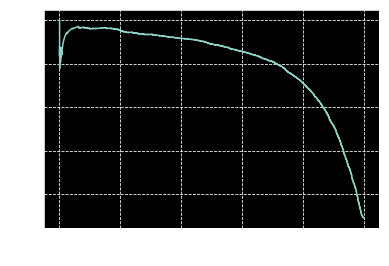

In [85]:
plt.close()
plt.plot(recalls,precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(linestyle='--')
plt.show()

In [86]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [80]:
threshold_90_precision

3370.0194991439557

In [81]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [82]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [83]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

#### ROC Curve 
Receiver Operating Characteristic 
>A common tool used with binary classifiers. Similar to precision/recall curve

>Plots true postivie rate(Recall) against false positive rate. <br>
FPR is the ratio of negative instances that are incorrectly classified as positive<br>
this equals to 1 - True negative rate (ratio of negative instances classified as negative)


TNR is called specifity - ROC plots sensitivity versus the 1 - specificity 

In [88]:
from sklearn.metrics import roc_curve

In [89]:
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

In [90]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],"k--") # dashed diagonal
    plt.xlabel("False Postive Rate")
    plt.ylabel("True positive Rate")
    plt.grid(linestyle='--')

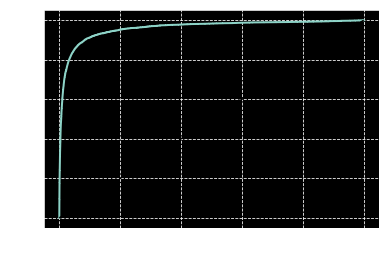

In [94]:
plot_roc_curve(fpr,tpr)
plt.show()

The higher the recall(TPR), the more false positives the classifier produces. 

Measuring the Area under the curve. A perfect classifier will have ROC AUC equal to 1.

In [95]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

Thumb rule for selecting ROC curve or the PR curve

    If positive class is rare or when you care more about the false positives than the false negative use PR curve otherwise use ROC curve
   

Training a random forest classifier

In [96]:
from sklearn.ensemble import RandomForestClassifier

In [98]:
forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf,x_train,y_train_5,cv=3,
                                   method='predict_proba')

C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In order to plot the ROC curve we need the scores and not the probablities

In [101]:
y_scores_forest = y_proba_forest[:,1] # probablity of positive class
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_5,y_scores_forest)

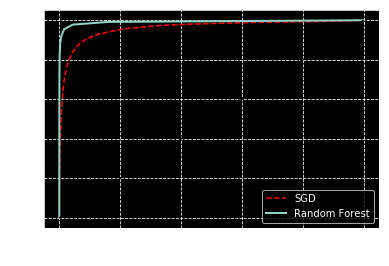

In [112]:
plt.plot(fpr,tpr,"r--",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,label="Random Forest")
plt.legend()
plt.show()


In [113]:
roc_auc_score(y_train_5,y_scores_forest)

0.9920527492698306

#### Multiclass Classification 